In [6]:
import sys
sys.path.append('../../')
import importlib
from models.utils import dataloader as loader
from models.gaussianprocess import gp_pipeline as p
from models.curvefit import curvefit_pipeline as p2
from models.gaussianprocess import gp_model as m
from models.utils import clustering as c
import matplotlib.pyplot as plt
import numpy as np

importlib.reload(m)
importlib.reload(loader)
importlib.reload(p)
importlib.reload(p2)

<module 'models.curvefit.curvefit_pipeline' from '../..\\models\\curvefit\\curvefit_pipeline.py'>

In [8]:
cases_pipeline = p2.Pipeline.load('../curvefit/saved_pipeline_cases.pl')

ModuleNotFoundError: No module named 'curvefit_pipeline'

In [83]:
val_steps = 2
gp_pipeline = p.Pipeline({}, {}, val_steps=val_steps)

Clustering......done clustering.
Processing data for cluster 260/260
Calculating best delay for cluster 260/260
Calculating training data for cluster 260/260


In [84]:
gp_pipeline.run(start=0)

fitting cluster 260/260


In [85]:
cases_pred = cases_pipeline.predictions
gp_pipeline.extend_cases_smooth(cases_pred)

In [86]:
horizon = 14
predictions = gp_pipeline.predict(horizon, d=10)

In [87]:
datadict = loader.load_covid_timeseries(smoothing=3, cases_cutoff=5)
cases_all = datadict['cases_raw']
deaths_all = datadict['deaths_raw']

In [126]:
county = 204
cases_raw = cases_all[county] 
deaths_raw = deaths_all[county]

# b = deaths_raw != 0
# deaths_raw = deaths_raw[b]
# cases_raw = cases_raw[b]

cases = np.diff(cases_raw)
deaths = np.diff(deaths_raw)

s = 7
cases_smooth = smooth_timeseries(cases, s)
deaths_smooth = smooth_timeseries(deaths, s)

z = cases_smooth

In [127]:
deaths_pipeline = p2.Pipeline.load('saved_pipeline_gp2.pl')
deaths_pred = deaths_pipeline.combined

(54,) (14, 9) (88, 9)


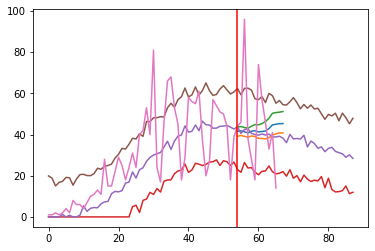

In [128]:
deaths = deaths[deaths != 0]
end = deaths.shape[0]
pred_start = end - 12
s = deaths[:-12]

print(s.shape, predictions[county].shape, deaths_pred[county].shape)

y1 = np.concatenate([s, predictions[county][:, 4]])
x = np.arange(pred_start, y1.shape[0])
plt.plot(x, y1[pred_start:])

y2 = np.concatenate([s, predictions[county][:, 0]])
x = np.arange(pred_start, y2.shape[0])
plt.plot(x, y2[pred_start:])

y3 = np.concatenate([s, predictions[county][:, 8]])
x = np.arange(pred_start, y3.shape[0])
plt.plot(x, y3[pred_start:])

x = np.arange(0, deaths_pred[county].shape[0])
y4 = deaths_pred[county][:, 0]
# y4[end:] = (y1[end:] + y4[end:]) / 2
plt.plot(x, y4)

y5 = deaths_pred[county][:, 4]
# y5[end:] = (y5[end:] + y2[end:]) / 2
plt.plot(x, y5)

y6 = deaths_pred[county][:, 8]
# y6[end:] = (y6[end:] + y3[end:]) / 2
plt.plot(x, y6)

x = np.arange(0, deaths.shape[0])
y = deaths
plt.plot(x, y)

plt.axvline(pred_start, color='red')

# plt.ylim(0, 250)
# plt.xlim(50,)

In [21]:
a = m.GPCasesDeathsModel()

In [46]:
c = 46
a.fit(gp_pipeline.cases_past[c], gp_pipeline.deaths_curr[c])

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, η, ρ]
Sampling chain 1, 0 divergences: 100%|██████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 217.03it/s]
C:\Users\kehua\AppData\Local\Programs\Python\python-venv\37_env\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
The acceptance probability does not match the target. It is 0.9141078247929509, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.890118009075018, but should be close to 0.8. Try to increase the number of tuni

LinAlgError: SVD did not converge

In [30]:
a.save(f'{c}.dat', 'gp_cluster')

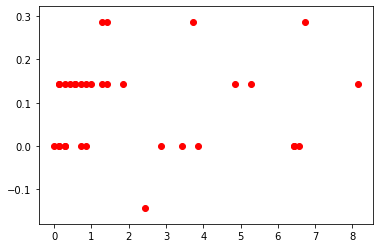

In [45]:
import matplotlib.pyplot as plt
c = 46
plt.scatter(gp_pipeline.cases_past[c], gp_pipeline.deaths_curr[c], color='red')

In [25]:
def smooth_timeseries(t, size=5, axis=0):
    '''Smooth the function by taking a moving average of "size" time steps'''
    average_filter = np.full((size, ), 1 / size)

    t = np.pad(t, [(size // 2 + (not size % 2), size // 2)], mode='median', stat_length=size)
    return np.apply_along_axis(lambda r: np.convolve(r, average_filter, mode='valid'), 
        axis=axis, arr=t)

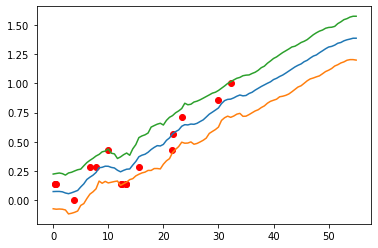

In [29]:
import numpy as np
x = np.linspace(0, 55, 100)
pred = a.predict(x)
s = 7
plt.plot(x, smooth_timeseries(pred[4], 7))
plt.plot(x, smooth_timeseries(pred[0], 7))
plt.plot(x, smooth_timeseries(pred[8], 7))
plt.scatter(gp_pipeline.cases_past[c], gp_pipeline.deaths_curr[c], color='red')

In [46]:
a.quantile_gp

In [47]:
import pickle

In [48]:
with open('test_quantile.dat', 'wb+') as handle:
    pickle.dump(a.quantile_gp, handle, 4)

In [49]:
with open('test_quantile.dat', 'rb+') as handle:
    s = pickle.load(handle)

In [51]:
def predict(x):
    deaths_curr = []
    for f in s:
        deaths_curr.append(f(x))
    return np.array(deaths_curr)

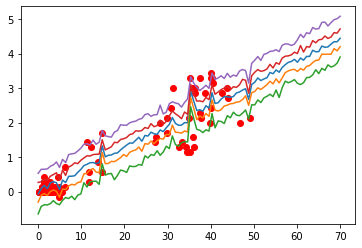

In [52]:
import numpy as np
x = np.linspace(0, 70, 100)
pred = predict(x)
plt.plot(x, pred[4])
plt.plot(x, pred[2])
plt.plot(x, pred[0])
plt.plot(x, pred[6])
plt.plot(x, pred[8])
plt.scatter(pipeline.cases_past[0], pipeline.deaths_curr[0], color='red')